In [33]:
import os
import sys
import gc
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')

In [34]:
mu = 1e-3 #dynamic viscosity of water

In [35]:
df_surface = pd.read_csv('surface_data-t=5.0.csv')

In [36]:
#Combine the components of the velocity gradient and the normal vectors into numpy arrays

df_surface['grad_U'] = df_surface[['grad(U):0', 'grad(U):1', 'grad(U):2', 'grad(U):3', 'grad(U):4', 'grad(U):5', 'grad(U):6', 'grad(U):7', 'grad(U):8']].values.tolist()
df_surface['grad_U'] = df_surface['grad_U'].apply(np.array)

df_surface['normals'] = df_surface[['Normals:0', 'Normals:1', 'Normals:2']].values.tolist()
df_surface['normals'] = df_surface['normals'].apply(np.array)

In [37]:
def surface_integrand(row):
    '''
    this method works out the vector which is used as the integrand for the surface integrals.
    
    It also multiplies it by the area of the cell so we can then sum the integrands up
    to approximate the surface integral.
    '''
    gradU = row['grad_U'].reshape(3, 3) #velocity gradient matrix
    norm_v = row['normals'] #surface normal vector
    p = row['p'] #pressure
    area = row['Area'] #cell area
    
    sigma = mu*(gradU + gradU.T) - p*np.identity(3)
    #added a minus sign here as discussed
    return (sigma@norm_v)*area

In [38]:
df_surface['surface_integrand']=df_surface.apply(surface_integrand, axis=1)

In [39]:
#to calculate the integral, simply sum up the surface_integrand column
z = df_surface['surface_integrand'].sum()
print(z)

[ 1.36359299e-10  9.61581755e-08 -3.03561445e-07]


In [40]:
def scale_w(row):
    #used this method to compare to the values given by the paraview volume integral
    return row['U:2']*row['Area']

In [41]:
df_surface['scaled_w']=df_surface.apply(scale_w, axis=1)

In [42]:
y = df_surface['scaled_w'].sum()
print(y)

5.2279892087705935e-08


In [43]:
# m = np.arange(9).reshape(3,3)
# u = np.power(10, np.arange(3))
# r = u*m
# print(m)
# print()
# print(u)
# print()
# print(r)

# v = np.sum(r, axis=1).reshape(3, 1)
# print(v)

In [44]:
df_volume = pd.read_csv('volume_data-t=5.0.csv')


In [45]:
#combine the seperate gradU, dUdt and U components into numpy arrays
df_volume['grad_U'] = df_volume[['grad(U):0', 'grad(U):1', 'grad(U):2', 'grad(U):3', 'grad(U):4', 'grad(U):5', 'grad(U):6', 'grad(U):7', 'grad(U):8']].values.tolist()
df_volume['grad_U'] = df_volume['grad_U'].apply(np.array)

df_volume['dUdt'] = df_volume[['dUdt:0', 'dUdt:1', 'dUdt:2']].values.tolist()
df_volume['dUdt'] = df_volume['dUdt'].apply(np.array)

df_volume['U'] = df_volume[['U:0', 'U:1', 'U:2']].values.tolist()
df_volume['U'] = df_volume['U'].apply(np.array)

In [46]:
def volume_integrand(row):
    
    U = row['U']
    dUdt = row['dUdt']
    gradU = row['grad_U'].reshape(3, 3)
    V = row['Volume']
    
    r = U*gradU.T #first step of calculating (U.grad)U

    UgradU = np.sum(r, axis=1) #second step of calculating (U.grad)U

    return (dUdt + UgradU)*V

In [47]:
df_volume['volume_integrand']=df_volume.apply(volume_integrand, axis=1)

In [48]:
#total volume integral
vi = df_volume['volume_integrand'].sum()
print(vi)

[-1.50297490e-14 -5.94765883e-13  2.29180392e-11]


In [49]:
#method to double check the volume integral method, using velocity
def scale_w(row):
    return row['U:1']*row['Volume']

In [50]:
df_volume['scaled_w']=df_volume.apply(scale_w, axis=1)

In [51]:
y = df_volume['scaled_w'].sum()
print(y)

8.856264967535774e-15


In [53]:
def calcDragOverTime(t_max, delta_t):
    t_list = []
    integ_vectors = [] #list to hold the vectors calculated from the integrals
    filename = 'drag_over_time.csv'
    
    with open(filename, 'w+') as file:
        
        file.write('t, F_x, F_y, F_z,\n')
        
        for t in np.arange(delta_t, t_max+delta_t, delta_t):
            t_string = "{:.1f}".format(t)
            print(t_string)
            
            #read in data
            df_surface = pd.read_csv('surface_data-t='+t_string+'.csv')
            df_volume = pd.read_csv('volume_data-t='+t_string+'.csv')

            #combine seperate component into arrays
            df_surface['grad_U'] = df_surface[['grad(U):0', 'grad(U):1', 'grad(U):2', 'grad(U):3', 'grad(U):4', 'grad(U):5', 'grad(U):6', 'grad(U):7', 'grad(U):8']].values.tolist()
            df_surface['grad_U'] = df_surface['grad_U'].apply(np.array)
            df_surface['normals'] = df_surface[['Normals:0', 'Normals:1', 'Normals:2']].values.tolist()
            df_surface['normals'] = df_surface['normals'].apply(np.array)

            df_volume['grad_U'] = df_volume[['grad(U):0', 'grad(U):1', 'grad(U):2', 'grad(U):3', 'grad(U):4', 'grad(U):5', 'grad(U):6', 'grad(U):7', 'grad(U):8']].values.tolist()
            df_volume['grad_U'] = df_volume['grad_U'].apply(np.array)
            df_volume['dUdt'] = df_volume[['dUdt:0', 'dUdt:1', 'dUdt:2']].values.tolist()
            df_volume['dUdt'] = df_volume['dUdt'].apply(np.array)
            df_volume['U'] = df_volume[['U:0', 'U:1', 'U:2']].values.tolist()
            df_volume['U'] = df_volume['U'].apply(np.array)

            #caluclate the integrands
            df_surface['surface_integrand']=df_surface.apply(surface_integrand, axis=1)
            df_volume['volume_integrand']=df_volume.apply(volume_integrand, axis=1)

            #sum everything up to calculate the integrals
            surf_int = df_surface['surface_integrand'].sum()
            vol_int = df_volume['volume_integrand'].sum()
            
            #changed the + to a - here as discussed
            total_int = surf_int - vol_int
            
            #append to list and save to file
            t_list.append(t)
            integ_vectors.append(total_int)
            data_string = "{:.2f}, {:.5e}, {:.5e}, {:.5e}\n".format(t, total_int[0], total_int[1], total_int[2])
            file.write(data_string)

            del df_surface, df_volume
            gc.collect()
            
    return t_list, integ_vectors

In [ ]:
t_vals, drag_vals = calcDragOverTime(t_max=15., delta_t=0.2)

0.2


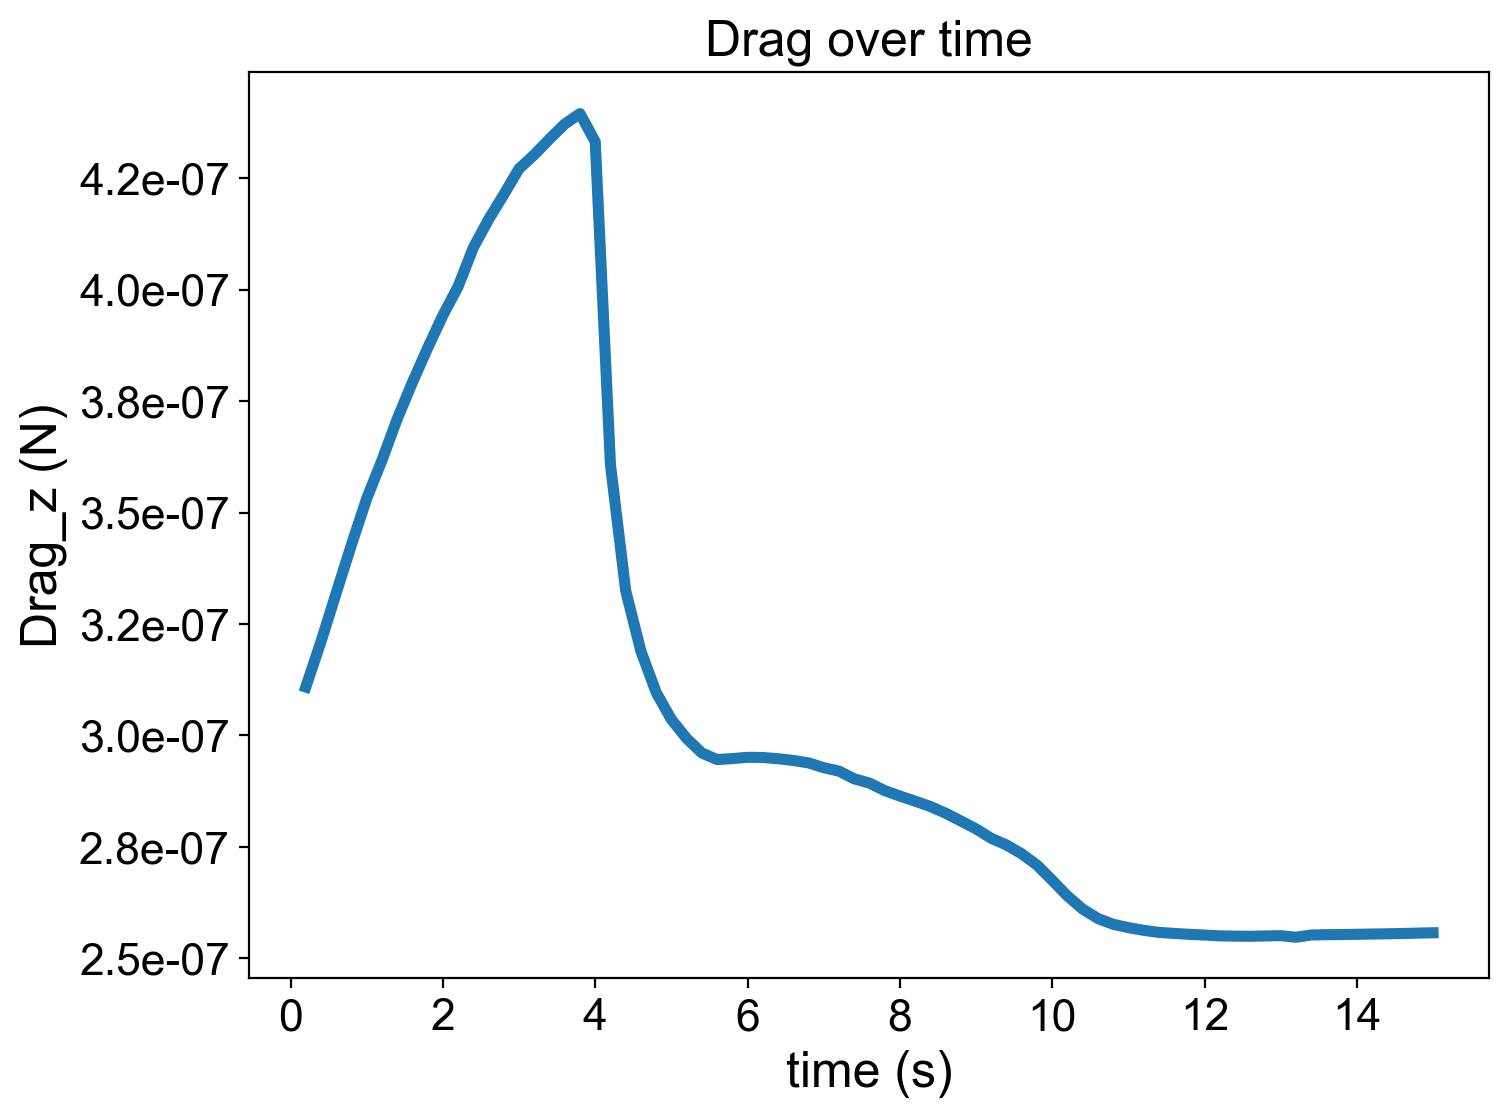

In [32]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
plt.rcParams['font.sans-serif'] = "Arial"

z_data = np.array(drag_vals)[:,2]
#print(z_data)
#t_vals = np.arange(delta_t, t_max+delta_t, delta_t)
ax.plot(t_vals, z_data, lw=4)
ax.set_title('Drag over time', fontsize=18)
ax.set_xlabel('time (s)', fontsize=18)
ax.set_ylabel('Drag_z (N)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.savefig('rough_integrals_v1.png', bbox_inches='tight')
plt.show()